In [1]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import lightning as L
import torchmetrics
import wandb
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from lightning.pytorch.loggers import WandbLogger

# Custom modules for loading n-MNIST dataset and plotting spike activity
from utils import read_dataset, get_nmnist, plot_spike_activity

wandb.login()  # Log in to your W&B account
L.seed_everything(42)

device = torch.device(torch.cuda.current_device()) if torch.cuda.is_available() else torch.device('cpu')
print('Available device:', device)

get_nmnist()

wandb: Currently logged in as: kapiotrow (deep-neural-network-course) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Seed set to 42


Available device: cuda:0
Done


Spiking Neural Networks (SNNs) are the **third generation of neural networks** — designed to more closely mimic the way biological neurons communicate.
Instead of using continuous activations (like ReLU or tanh), SNNs use **discrete events** or **spikes** to transmit information over time.

A neuron in an SNN maintains an internal **membrane potential** ( $V_t$ ) that evolves over time based on its inputs.
When this potential crosses a threshold ( $\theta$ ), the neuron emits a spike (binary output `1`) and resets its potential.

This makes SNNs **temporal** and **energy-efficient**, ideal for event-based sensors such as **neuromorphic vision** (e.g. N-MNIST from previous labs), but can be also applied to traditional datasets by encoding inputs into spike trains.

There are several neuron models used in SNNs, with the **Leaky Integrate-and-Fire (LIF)** model being one of the most popular due to its balance between biological realism and computational efficiency. 

<img src='https://raw.githubusercontent.com/vision-agh/DNN-Course-media/refs/heads/main/lab10_snn/figures/lif.png' width='600'/>

The membrane potential ( $V_t$ ) in LIF is updated according to:

$$
V_t = \beta V_{t-1} + I_t - S_{t-1} \cdot \theta
$$

Where:

* ( $\beta \in [0,1]$ ) — *leak constant* (how much of previous potential is retained),
* ( $I_t$ ) — input current at time step ( t ),
* ( $\theta$ ) — threshold potential,
* ( $S_{t-1}$ ) — previous spike output (1 if neuron fired, 0 otherwise).

A spike is generated when:

$$
S_t = H(V_t - \theta)
$$

where ( $H(\cdot)$ ) is the **Heaviside step function** (0 for negative inputs, 1 otherwise).

## The Problem: Non-Differentiability of Spikes

The Heaviside step function is **not differentiable** — its gradient is zero almost everywhere, which prevents training SNNs using standard backpropagation.

To overcome this, we use **surrogate gradients**, which replace the non-differentiable step with a smooth approximation during the backward pass.

During forward propagation:
$$
S_t = H(V_t - \theta)
$$
During backpropagation, we approximate:
$$
\frac{dH(x)}{dx} \approx \sigma'(x)
$$
where ( $\sigma'(x)$ ) is a differentiable function (e.g. sigmoid, fast sigmoid, or arctangent).

This allows SNNs to be trained using gradient descent, just like conventional ANNs.


## ATan Surrogate Gradient

In this implementation, we use the **arctangent (ATan)** surrogate gradient function. For different types of surrogate gradients, refer to the [List of Surrogate Gradients](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html#module-snntorch.surrogate).

Forward pass:
$$
S_t =
\begin{cases}
1, & \text{if } V_t > \theta \\
0, & \text{otherwise}
\end{cases}
$$

Backward pass (surrogate gradient):
$$
\frac{dS_t}{dV_t} = \frac{\alpha}{2 \left(1 + \left(\frac{\pi}{2} \alpha (V_t - \theta)\right)^2 \right)}
$$

where:

* ( $\alpha$ ) controls the steepness of the gradient.
* For larger ( $\alpha$ ), the gradient becomes sharper and closer to the true step.


#### TODO
Finish the implementation of the ATan surrogate gradient function below. Remember that in forward function, output (spikes) must be binary (0 or 1) stored as float tensors and in backpropagation, we multiply the incoming gradient ($grad_{out}$) by the surrogate gradient (chain rule of training). 

In [2]:
class ATanSurrogateFn(torch.autograd.Function):
    """
    Surrogate gradient for the Heaviside step function using the arctangent derivative.

    Forward:
        y = 1 if x > 0 else 0
    Backward:
        dy/dx ≈ α / 2 / (1 + (π/2 * α * x)²)

    Args:
        alpha (float): scaling factor controlling sharpness of the gradient.
    """
    @staticmethod
    def forward(ctx, input_, alpha):
        ctx.save_for_backward(input_)
        ctx.alpha = alpha
        return (input_ > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        (input_,) = ctx.saved_tensors
        alpha = ctx.alpha

        grad = grad_output * (alpha / (2 * (1 + ((np.pi/2) * alpha * input_)**2)))
        return grad, None

def atan_surrogate(alpha: float = 2.0):
    """
    Returns a callable surrogate activation function with ATan gradient.
    """
    def _surrogate(x):
        return ATanSurrogateFn.apply(x, alpha)
    return _surrogate

We can check if our implementation of surrogate gradient is correct by plotting the gradients for different values of ( $\alpha$ ) and comparing them to the Heaviside step function.

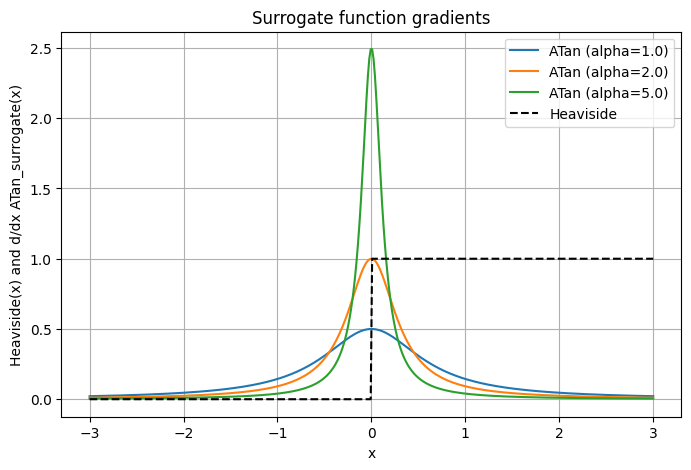

In [3]:
# Example input data
x = torch.linspace(-3, 3, 400, requires_grad=True)
y_heaviside = (x > 0).float()
grad_out = torch.ones_like(x)

# calculate gradients
alphas = [1.0, 2.0, 5.0]
grads = []
for a in alphas:
    y = atan_surrogate(alpha=a)(x)
    y.backward(torch.ones_like(x), retain_graph=True)
    grads.append(x.grad.clone())
    x.grad.zero_()

# wykres
plt.figure(figsize=(8, 5))
for a, g in zip(alphas, grads):
    plt.plot(x.detach(), g.detach(), label=f'ATan (alpha={a})')
plt.plot(x.detach(), y_heaviside, 'k--', label='Heaviside')
plt.title('Surrogate function gradients')
plt.xlabel('x')
plt.ylabel('Heaviside(x) and d/dx ATan_surrogate(x)')
plt.legend()
plt.grid(True)
plt.show()

Now, we can implement the LIF neuron model using the ATan surrogate gradient (or any other surrogate function).

## What the LIF neuron does

A LIF neuron maintains a membrane potential ($V_t$). It **leaks** over time, **integrates** new input ($I_t$), **fires** when crossing a threshold ($\theta$), then **resets**. Lets remind the equation from above:

$$
V_t = \beta V_{t-1} + I_t - S_{t-1} \cdot \theta
$$

Where:

* ( $\beta \in [0,1]$ ) — *leak constant* (how much of previous potential is retained),
* ( $I_t$ ) — input current at time step ( t ),
* ( $\theta$ ) — threshold potential,
* ( $S_{t-1}$ ) — previous spike output (1 if neuron fired, 0 otherwise).

The neuron **fires a spike** when the membrane potential crosses the threshold:

$$
S_t = H(V_t - \theta)
$$


In our implementation, both the **leak constant** ( $\beta$ ) and **threshold** ( $\theta$ ) can be **learnable parameters**, allowing the neuron to adapt its time constant and firing sensitivity during training.

We also introduce an additional scaling factor ( $\gamma$ ) (`graded_spikes_factor`), which **controls the amplitude of spikes**.

Instead of emitting binary 0/1 spikes, we can scale their magnitude:

$$
V_t = \beta V_{t-1} + I_t - S_{t-1} \cdot \theta \cdot \gamma
$$

and the generated spike becomes:

$$
S_t = \gamma \cdot H(V_t - \theta)
$$


### TODO

Your goal is to define the **forward pass** of the LIF neuron following the equations above.

Define the LIF forward pass according to the equations above and using methods `_spike` and `_reset`. Belowe is overview of the steps to implement in the `forward` method:

1. **Integrate Input and Apply Leak**: Update the membrane potential using the leak constant and input:
    $$
    base = \beta V_{t-1} + I_t
    $$

    $\beta$ is clamped between 0 and 1 to ensure stability.

2. **Apply Reset Based on Previous Spike**: Calculate the spikes from the previous time step membrane potential and use them to reset the current potential:
    $$
    V_t = base - S_{t-1} \cdot \theta \cdot \gamma
    $$

    Note that the previous spike ( $S_{t-1}$ ) used for reset should be detached from the computation graph to prevent gradients from flowing through time incorrectly.

3. **Generate New Spike**: Use the surrogate gradient function again on the updated membrane potential to determine if a spike occurs:
    $$
    S_t = \gamma \cdot H(V_t - \theta)
    $$
4. **Update Memory State**: Store the updated membrane potential for the next time step.

In [4]:
class LIF(nn.Module):
    """
    Leaky Integrate-and-Fire (LIF) spiking neuron.

    Args:
        spike_grad (callable): surrogate gradient function mapping pre-activation -> spike (0/1 in fwd).
        beta (float or Tensor): membrane decay in [0, 1].
        threshold (float or Tensor): firing threshold.
        graded_spikes_factor (float or Tensor): scales spike amplitude.
        learn_beta (bool): make beta learnable.
        learn_threshold (bool): make threshold learnable.
        learn_graded_spikes_factor (bool): make graded factor learnable.
    """

    def __init__(
        self,
        spike_grad,
        beta: float = 0.5,
        threshold: float = 1.0,
        graded_spikes_factor: float = 1.0,
        learn_beta: bool = False,
        learn_threshold: bool = False,
        learn_graded_spikes_factor: bool = False,
    ):
        super().__init__()

        # --- Surrogate gradient ---
        self.spike_grad = spike_grad

        # --- Memory state ---
        self.register_buffer("mem", torch.zeros(0), persistent=False)

        # --- Parameters ---
        self.beta = self._make_param(beta, learn_beta)
        self.threshold = self._make_param(threshold, learn_threshold)
        self.graded_spikes_factor = self._make_param(graded_spikes_factor, learn_graded_spikes_factor)

    # ---------------------------------------------------------
    # Forward
    # ---------------------------------------------------------
    def forward(self, x: torch.Tensor):
        """
        Forward pass for one timestep.

        Args:
            x (Tensor): input current (same shape as membrane state)
        Returns:
            spk_t (Tensor): spikes at current timestep
            mem_t (Tensor): updated membrane potential
        """
        # Initialize membrane if first step or shape changed
        if self.mem.shape != x.shape:
            self.mem = torch.zeros_like(x, device=x.device)

        # Integrate input and apply leak
        base = torch.clamp(self.beta, 0.0, 1.0) * self.mem + x

        # Previous step spike (detached from graph!)
        reset_prev = self._spike(self.mem).detach()

        # Apply reset based on previous spike
        mem_t = self._reset(base, reset_prev)

        # Generate new spike
        spk_t = self._spike(mem_t)

        # Update memory state
        self.mem = mem_t

        return spk_t, mem_t
    
    # ---------------------------------------------------------
    # LIF computations
    # ---------------------------------------------------------
    def _spike(self, mem_like: torch.Tensor) -> torch.Tensor:
        """Compute spike activation (0/1) using surrogate gradient."""
        return self.spike_grad(mem_like - self.threshold) * self.graded_spikes_factor

    def _reset(self, membrane: torch.Tensor, reset_prev: torch.Tensor) -> torch.Tensor:
        """Subtract threshold from membrane where previous spike occurred."""
        return membrane - reset_prev * self.threshold
    
    # ---------------------------------------------------------
    # Utility functions
    # ---------------------------------------------------------
    @staticmethod
    def _make_param(value, learnable: bool):
        """Convert a scalar/tensor into a (possibly learnable) parameter."""
        tensor = torch.as_tensor(value, dtype=torch.float)
        return nn.Parameter(tensor, requires_grad=learnable)

    def reset_mem(self):
        """Reset membrane potential to zero."""
        self.mem = torch.zeros_like(self.mem, device=self.mem.device)
        return self.mem

    def __repr__(self):
        name = getattr(self.spike_grad, "__name__", type(self.spike_grad).__name__)
        return (
            f"{self.__class__.__name__}("
            f"spike_grad={name}, "
            f"beta={self.beta.item():.3f}, "
            f"threshold={self.threshold.item():.3f}, "
            f"graded_spikes_factor={self.graded_spikes_factor.item():.3f})"
        )

print(LIF(spike_grad=atan_surrogate(), beta=0.7, threshold=1.0, graded_spikes_factor=1.0))

LIF(spike_grad=_surrogate, beta=0.700, threshold=1.000, graded_spikes_factor=1.000)


Let’s now focus on the dataset we’ll use to train and evaluate our Spiking Neural Network.

For this lab, we will use again the **N-MNIST** dataset, which is an event-based version of the classic MNIST dataset. As we know, this datasets is already in spike format, so we do not need to encode the inputs into spike trains. 

Feeding individual events directly into an SNN might seem ideal since the data is already in spike form, but:
1. It would make training extremely slow, as each event is processed separately (1000s per sample).
2. The training process would be unstable, since gradients would need to propagate through highly sparse, irregular event sequences.

To handle this, we accumulate events into temporal windows — grouping many events into a single spike frame.
1. Each frame represents events collected over a small time window (e.g. 1 ms).
2. Stacking these frames over time gives us a sequence, similar to a short video of spikes.

Our custom N-MNIST dataset returns samples as tensors with shape ( `T x C x H x W` ), where:
* ( `T` ) — number of time steps (frames),
* ( `C` ) — number of channels (2 for ON and OFF events),
* ( `H` ) — height of the frame,
* ( `W` ) — width of the frame.

We are using `index_put_` with `accumulate=True` to accumulate every event that falls into the same time-frame, pixel and polarity, and futher we clip it to max value of 5 events and normalise it to range [0, 1].

In [5]:
class NMNIST(torch.utils.data.Dataset):
    """
    Neuromorphic MNIST dataset loader.
    Converts event-based data into a dense tensor of shape (T, 2, H, W),
    where:
        - T: number of temporal bins
        - 2: polarity channels (ON/OFF)
        - H, W: spatial resolution
    """

    def __init__(self, data_dir: str, T: int = 32):
        self.data_dir = data_dir
        self.event_files = glob.glob(os.path.join(data_dir, "*/*"))
        self.H, self.W = 32, 32
        self.T = T

    def __len__(self):
        return len(self.event_files)

    def __getitem__(self, idx):
        event_file = self.event_files[idx]

        # Label = parent folder name
        label = int(os.path.basename(os.path.dirname(event_file)))
        y = torch.tensor(label, dtype=torch.long)

        # Load event data
        timestamps, xaddr, yaddr, pol = read_dataset(event_file)

        # Select 100 ms window
        mask = (timestamps >= 100_000) & (timestamps < 200_000)
        timestamps, xaddr, yaddr, pol = (
            timestamps[mask], xaddr[mask], yaddr[mask], pol[mask]
        )

        # Initialize voxel grid: (T, 2, H, W)
        data_tensor = torch.zeros((self.T, 2, self.H, self.W), dtype=torch.float32)

        # Return empty tensor if no events
        if len(timestamps) == 0:
            return {"x": data_tensor, "y": y}

        # Normalize timestamps into [0, T-1] bins
        t_min, t_max = timestamps.min(), timestamps.max()
        if t_max > t_min:
            t_norm = (self.T - 1) * (timestamps - t_min) / (t_max - t_min)
        else:
            t_norm = np.zeros_like(timestamps, dtype=np.float32)

        t_idx = np.clip(t_norm.astype(np.int64), 0, self.T - 1)

        # Convert to tensors
        ts = torch.from_numpy(t_idx).long()
        xs = torch.from_numpy(xaddr).long().clamp(0, self.W - 1)
        ys = torch.from_numpy(yaddr).long().clamp(0, self.H - 1)
        ps = torch.from_numpy(pol).long().clamp(0, 1)

        # Accumulate event counts
        ones = torch.ones_like(ts, dtype=torch.float32)
        data_tensor.index_put_((ts, ps, ys, xs), ones, accumulate=True)

        # Clip and normalize to [0, 1]
        data_tensor = torch.clamp(data_tensor, 0, 5) / 5.0

        return {"x": data_tensor, "y": y}

train_dataset = NMNIST("Train")
test_dataset = NMNIST("Test")

# Inspect one sample
x, y = train_dataset[0]['x'], train_dataset[0]['y']
print("Single sample:")
print("  Data shape:", x.shape)   # (T, 2, H, W)
print("  Label:", y.item())

Single sample:
  Data shape: torch.Size([32, 2, 32, 32])
  Label: 8


After defining the dataset, we can create dataloaders for training and testing. To stack samples into batches, we define a custom collate function that stacks the individual samples along a new batch dimension. For later use, we permute the data to have final shape ( `T x B x C x H x W` ), as we will be iterating over time steps during training.

In [6]:
def collate_fn(batch_list):
    xs = [d["x"] for d in batch_list]
    ys = [d["y"] for d in batch_list]

    # Stack per batch (B, T, 2, H, W)
    x = torch.stack(xs, dim=0)
    y = torch.stack(ys, dim=0).squeeze()

    # Move time dimension first → (T, B, 2, H, W)
    x = x.permute(1, 0, 2, 3, 4).contiguous()
    return {"x": x, "y": y}


# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=16, collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=16, collate_fn=collate_fn
)

# Test one batch
for batch in train_dataloader:
    print("\nBatch loaded:")
    print("  x:", batch["x"].shape)  # (T, B, 2, H, W)
    print("  y:", batch["y"].shape)  # (B,)
    break


Batch loaded:
  x: torch.Size([32, 64, 2, 32, 32])
  y: torch.Size([64])


Now that we have implemented our **Leaky Integrate-and-Fire (LIF)** neuron with surrogate gradients, it’s time to test it in a full network!

We’ll build a **feedforward spiking neural network (SNN)** that uses LIF neurons as activation functions between linear layers.
This network will be trained on the **N-MNIST** dataset using **Backpropagation Through Time (BPTT)** — similar to training a recurrent neural network.

Our network will consist of **two hidden LIF layers** and **three fully connected (linear) layers**.

1. Linear: (32×32×2) → 128 
2. LIF neuron,
3. Linear: 128 → 128 
4. LIF neuron,
5. Linear: 128 → 10 (output layer for 10 classes)

Each LIF neuron is parameterized as:

* ( $\beta$ = 0.7 )
* ( $\theta$ = 1.0 )
* ( $\gamma$ = 1.0 ) (`graded_spikes_factor`)
* All parameters (`beta`, `threshold`, and `graded_spikes_factor`) **set as learnable**

### TODO

Your task is to complete the two core methods of this model: `forward_step` and `forward`.

In `forward_step`, we process input at a single time step through the network layers, applying LIF activations after each linear layer. We assume that input data is already flattened to shape $((B, C \times H \times W))$. Each LIF neuron returns both the spike output and updated membrane potential; use the spike output for the first neuron and the **memory** for the second (we are using the membrane potential of the second LIF to classify with the final linear layer). This method returns the final output from the last layer and a tuple of membrane potentials and spikes from each LIF layer, `(spk1, spk2)` and `(mem1, mem2)`.

In `forward`, we iterate over the time dimension of the input data, calling `forward_step` at each time step. Before processing, we reset the membrane potentials of all LIF neurons to zero using `reset_mems`. The input tensor for timestamp ( t ) needs to be `view`ed to shape $((B, C \times H \times W))$. Accumulate outputs (last-layer logits, spikes, and membrane potentials) over all time steps into separate lists and return them.


### Important information

In our example, we are using the membrane potential of the second LIF layer (`mem2`) for classification by passing it to the final linear layer. This is a common approach in SNNs, as the membrane potential contains more information about the neuron’s state than just the spike output. Of course, there are other strategies, such as using spike counts or temporal averages, depending on the specific application and desired behavior of the network.

In [12]:
class LIFLinear(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = atan_surrogate(alpha=2.0)

        self.fc1 = nn.Linear(2 * 32 * 32, 512)
        self.lif1 = LIF(spike_grad=spike_grad, beta=0.7, threshold=1.0)
        
        self.fc2 = nn.Linear(512, 256)

        self.lif2 = LIF(spike_grad=spike_grad, beta=0.7, threshold=1.0)
        
        self.fc3 = nn.Linear(256, 10)

    def forward_step(self, x):
        # x: (B, C*H*W)
        h1 = self.fc1(x)
        spk1, mem1 = self.lif1(h1)

        h2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(h2)

        out = self.fc3(mem2)

        spikes = (spk1, spk2)
        mems = (mem1, mem2)
        return out, spikes, mems

    def forward(self, x):
        # x: (T, B, C, H, W)
        T, B, C, H, W = x.shape
        outs = []
        out_spikes = []
        out_mems = []

        self.reset_mems()
        
        for t in range(T):
            xt = x[t].view(B, C * H * W)
            out_t, spikes_t, mems_t = self.forward_step(xt)

            outs.append(out_t)
            out_spikes.append(spikes_t)
            out_mems.append(mems_t)

        return outs, out_spikes, out_mems
    
    def reset_mems(self):
        for m in self.modules():
            if isinstance(m, LIF):
                m.reset_mem()


Check if you get correct output shapes after implementing the model.

In [13]:

input = torch.randn(32, 4, 2, 32, 32).to(device) # (T, B, C, H, W)
net = LIFLinear().to(device)
out, _, _ = net(input)

print(out[-1].shape)
print(net)

torch.Size([4, 10])
LIFLinear(
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (lif1): LIF(spike_grad=_surrogate, beta=0.700, threshold=1.000, graded_spikes_factor=1.000)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (lif2): LIF(spike_grad=_surrogate, beta=0.700, threshold=1.000, graded_spikes_factor=1.000)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


We are wraping up model in Lightning module. To calculate the loss, we will use the final output of the last linear layer to get logits for classification. We will use `CrossEntropyLoss` as our loss function.

At the end of module, we have defined methods for visualisation of spikes and membrane potentials over time for a given batch. You can check it on W&B.

In [14]:
class LIFMNIST(L.LightningModule):
    """
    PyTorch Lightning module for training an SNN on NMNIST-like data.
    """

    def __init__(self, lr: float = 1e-3, weight_decay: float = 1e-5):
        super().__init__()
        self.save_hyperparameters()

        # --- Model and loss ---
        self.model = LIFLinear()
        self.criterion = nn.CrossEntropyLoss()

        # --- Optimizer params ---
        self.lr = lr
        self.weight_decay = weight_decay

        # --- Metrics ---
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

        # --- Visualization buffers ---
        self.example_spikes = None
        self.example_mems = None

    # Training logic
    def step(self, batch):
        """Shared step logic for train/val/test."""
        x, y = batch["x"], batch["y"]

        outs, spikes, mems = self.model(x)
        out = outs[-1]  # final time step output

        loss = self.criterion(out, y)
        preds = out.argmax(dim=1)
        batch_size = y.size(0)

        # Save example spikes/membranes for visualization
        self._save_spikes_mems(spikes, mems)

        return loss, preds, y, batch_size

    def training_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.train_acc(preds, y)

        self.log_dict(
            {"train_loss": loss, "train_acc": acc},
            prog_bar=True, on_step=True, on_epoch=True, batch_size=batch_size
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.val_acc(preds, y)

        self.log_dict(
            {"val_loss": loss, "val_acc": acc},
            prog_bar=True, on_epoch=True, batch_size=batch_size
        )
        return loss

    def test_step(self, batch, batch_idx):
        loss, preds, y, batch_size = self.step(batch)
        acc = self.test_acc(preds, y)

        self.log_dict(
            {"test_loss": loss, "test_acc": acc},
            prog_bar=True, on_epoch=True, batch_size=batch_size
        )
        return loss

    # Optimizer setup
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

    # Spike & membrane recording for visualization
    def _save_spikes_mems(self, spikes, mems):
        """Save one batch of spike/membrane history for visualization."""
        if self.training or self.example_spikes is not None:
            return

        n_layers = len(spikes[0])
        self.example_spikes = [
            torch.stack([spikes_t[i].detach().cpu() for spikes_t in spikes], dim=0)
            for i in range(n_layers)
        ]
        self.example_mems = [
            torch.stack([mems_t[i].detach().cpu() for mems_t in mems], dim=0)
            for i in range(n_layers)
        ]

    # End of validation epoch - visualization
    def on_validation_epoch_end(self):
        """Visualize spike raster + membrane heatmaps on W&B."""
        if self.example_spikes is None or self.global_rank != 0:
            return

        fig = plot_spike_activity(
            self.example_spikes,
            self.example_mems,
            max_neurons=128,
            layer_names=["LIF1", "LIF2"]
        )

        self.logger.experiment.log({"spike_activity": wandb.Image(fig)})
        plt.close(fig)

        self.example_spikes, self.example_mems = None, None

And training begins!

In [15]:
wandb_logger = WandbLogger(project="lab10-snn", 
                           entity="deep-neural-network-course",
                           group="snn",
                           name="Karolina Piotrowska",
                           log_model=True)

model = LIFMNIST()

trainer = L.Trainer(
    max_epochs=5,
    logger=wandb_logger,
    log_every_n_steps=50
)

trainer.fit(model, train_dataloader, test_dataloader)
trainer.test(model, test_dataloader)
wandb.finish()

# Check learned parameters (look for beta, threshold, graded_spikes_factor)
print(model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/karolina/studia/gsn/venv/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | LIFLinear          | 1.2 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
-------------

Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 43.47it/s, v_num=jeyr, train_loss_step=0.0186, train_acc_step=1.000, val_loss=0.320, val_acc=0.929, train_loss_epoch=0.147, train_acc_epoch=0.956] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 43.40it/s, v_num=jeyr, train_loss_step=0.0186, train_acc_step=1.000, val_loss=0.320, val_acc=0.929, train_loss_epoch=0.147, train_acc_epoch=0.956]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 78.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.929099977016449
        test_loss           0.3202265501022339
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc_epoch,▁▆▇██
train_acc_step,▁▆▆▇▇▇▇▇▇█▇▇▇▇██▇▇██▇███▇▇█▇██████▇█████
train_loss_epoch,█▃▂▁▁
train_loss_step,█▄▄▃▄▄▃▂▄▄▂▃▁▅▂▃▄▁▂▃▁▃▃▆▄▂▄▃▂▂▃▂▂▃▂▁▂▂▂▃
trainer/global_step,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
val_acc,▁▄▇▇█
val_loss,█▅▃▂▁
epoch,5


LIFMNIST(
  (model): LIFLinear(
    (fc1): Linear(in_features=2048, out_features=512, bias=True)
    (lif1): LIF(spike_grad=_surrogate, beta=0.700, threshold=1.000, graded_spikes_factor=1.000)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (lif2): LIF(spike_grad=_surrogate, beta=0.700, threshold=1.000, graded_spikes_factor=1.000)
    (fc3): Linear(in_features=256, out_features=10, bias=True)
  )
  (criterion): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)


## TODO

Using the implemented dataset and LIF neuron model, define your own CNN-SNN architecture for classifying N-MNIST dataset.

You can try architectures like:
1. CNN layers with LIF activations and Linear classifier with ReLU activations.
2. CNN layers with ReLU activations and Linear classifier with LIF activations.
3. Fully LIF-based networks.

You can try using membrane potentials or spike counts from different layers for classification or accumulating spikes over time.